## **Loading necessary libraries**

In [ ]:
!pip install statsmodels==0.12.2

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

from keras.layers import Dense, SimpleRNN


## **Dataset and its information**


*   Dataset used - The SUNSPOTS dataset from statsmodels' datasets
  



In [ ]:
#loading the dataset
data = sm.datasets.sunspots.load_pandas()

In [ ]:
#viewing the dataset
data.data

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [ ]:
type(data.data)

pandas.core.frame.DataFrame

In [ ]:
data.data['YEAR']=pd.to_numeric(data.data['YEAR'].values, downcast='integer')

In [ ]:
data = pd.DataFrame(data.data)
data

,YEAR,SUNACTIVITY
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0
...,...,...
304,2004,40.4
305,2005,29.8
306,2006,15.2
307,2007,7.5


In [ ]:
data['SUNACTIVITY'].describe(include = 'all')

count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: SUNACTIVITY, dtype: float64

In [ ]:
data.isna().any()

YEAR           False
SUNACTIVITY    False
dtype: bool

Text(0.5, 1.0, 'Sunspots')

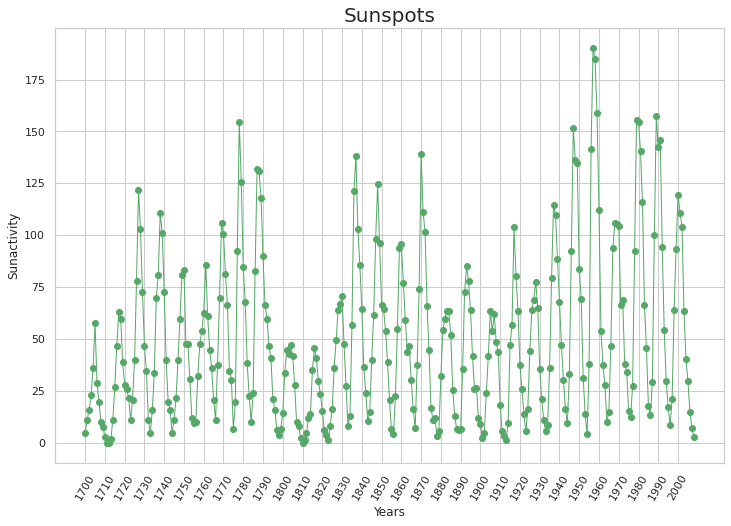

In [ ]:
#plotting the data(lineplot)

plt.figure(figsize=(12,8))
plt.xticks(np.arange(min(data['YEAR']), max(data['YEAR'])+1, 10),rotation=60)
plt.xlabel('Years')
plt.ylabel('Sunactivity')
plt.plot(data['YEAR'],data['SUNACTIVITY'],'go-',linewidth=1)


plt.title('Sunspots', fontsize=20)


Text(0.5, 1.0, 'Sunspots')

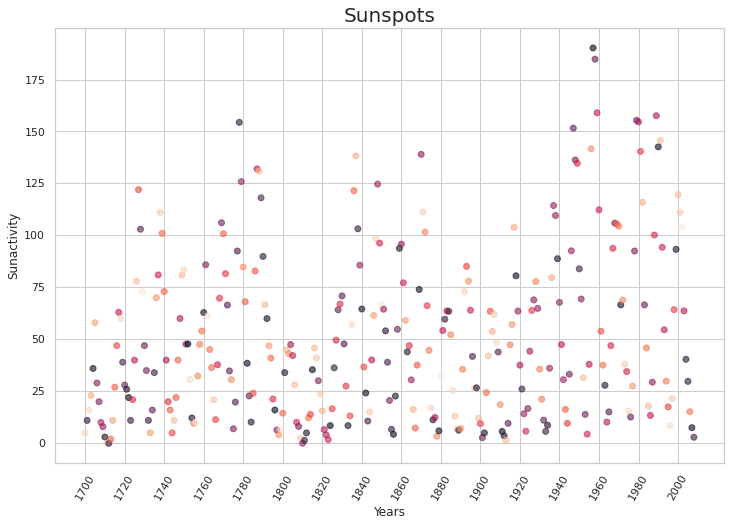

In [ ]:
#scatterplot
plt.figure(figsize=(12,8))
plt.xticks(np.arange(min(data['YEAR']), max(data['YEAR'])+1, 20),rotation=60)
plt.xlabel('Years')
plt.ylabel('Sunactivity')
colors = np.random.rand(309)

plt.scatter(data.YEAR,data.SUNACTIVITY,c=colors,alpha=0.6)


plt.title('Sunspots', fontsize=20)


# **Stationarity tests**

1. **Data Visualisation**

Text(0.5, 1.0, 'Sunspots')

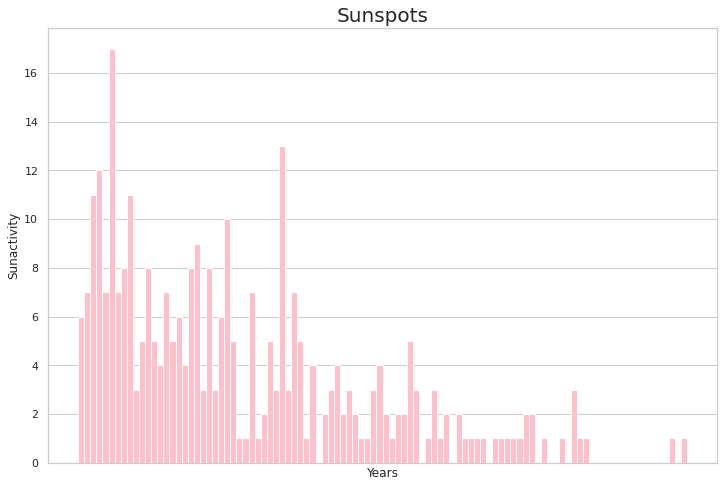

In [ ]:
plt.figure(figsize=(12,8))
plt.xticks(np.arange(min(data['YEAR']), max(data['YEAR'])+1, 20),rotation=60)
plt.xlabel('Years')
plt.ylabel('Sunactivity')
colors = np.random.rand(309)

plt.hist((data['SUNACTIVITY']),color= 'pink',bins=100)

plt.title('Sunspots', fontsize=20)


It can be concluded from the figure that data is unevenly distributed, making it non stationary.


2. **Checking Mean**

In [ ]:
X = data.SUNACTIVITY.values
split = int(len(X)/3 )
X1,X2 = X[0:split],X[split*2:split*3]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=45.269903, mean2=62.150485
variance1=1260.130065, variance2=2278.022888


The dataset is split into 3 parts and the means of 1st and 3rd part is compared. It's clear from the differnce in both means(mean1 and mean2) that data is non-stationary.

3. **ADF and KPSS tests**

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['SUNACTIVITY'].values)
print('ADF Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
   
else:
    print ("Time Series is Non-Stationary")

ADF Statistics:  -2.837780724938198
p-value:  0.05307642172812019
Critical Values:
1% -3.4523371197407404
5% -2.871222860740741
10% -2.571929211111111
Time Series is Non-Stationary


In [ ]:
from statsmodels.tsa.stattools import kpss
result = kpss(data['SUNACTIVITY'].values,lags='auto')
print('KPSS Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[3].items():
    print(key, value)

if result[0] > result[3]["5%"]:
    print ("Time Series is not Stationary")
else:
    print ("Time Series is Stationary")

KPSS Statistics:  0.6698662984667937
p-value:  0.01628488195756421
Critical Values:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739
Time Series is not Stationary


Both ADF and KPSS tests show that the data is non stationary. 

***Making the data stationary using differencing***

In [ ]:
data['sun_diff'] = data['SUNACTIVITY'].diff(periods=1)

diff_vals = data['sun_diff'][1:]
diff_vals= pd.DataFrame(diff_vals,columns=['sun_diff'])
diff_vals

,sun_diff
1,6.0
2,5.0
3,7.0
4,13.0
5,22.0
...,...
304,-23.3
305,-10.6
306,-14.6
307,-7.7


Text(0.5, 1.0, 'Sunspots')

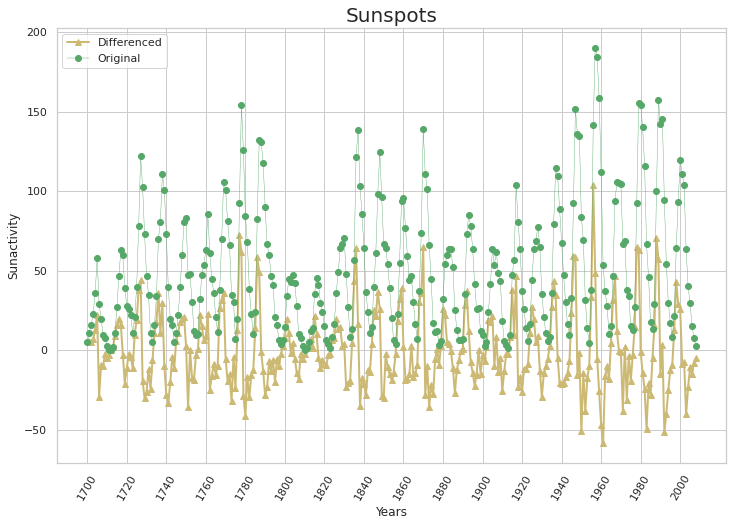

In [ ]:
#plotting the differenced series 
plt.figure(figsize=(12,8))
plt.xticks(np.arange(min(data['YEAR']), max(data['YEAR'])+1, 20),rotation=60)
plt.xlabel('Years')
plt.ylabel('Sunactivity')
plt.plot(data['YEAR'][1:],diff_vals.sun_diff,'y^-',linewidth=2,label='Differenced')
plt.plot(data['YEAR'],data['SUNACTIVITY'],'go-',linewidth=0.4,label='Original')
plt.legend(loc='upper left')
plt.title('Sunspots', fontsize=20)

***Verifying that data is now stationary after differncing***

1. **Visualization**

Text(0.5, 1.0, 'Sunspots')

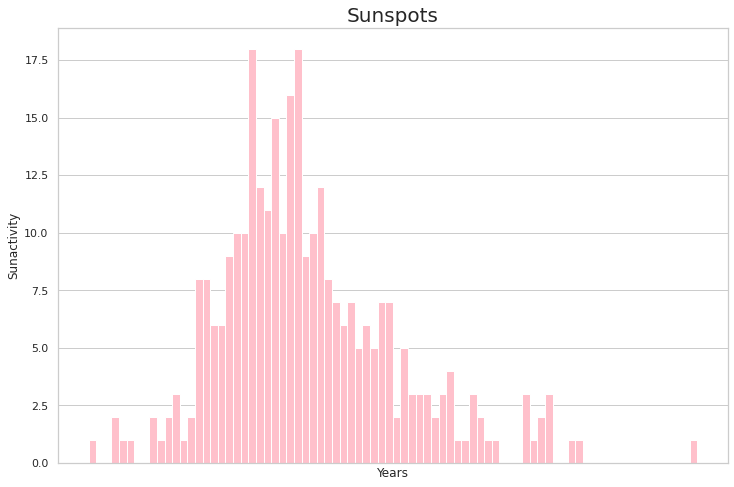

In [ ]:
plt.figure(figsize=(12,8))
plt.xticks(np.arange(min(data['YEAR']), max(data['YEAR'])+1, 20),rotation=60)
plt.xlabel('Years')
plt.ylabel('Sunactivity')
colors = np.random.rand(309)

plt.hist((diff_vals.sun_diff),color= 'pink',bins=80)

plt.title('Sunspots', fontsize=20)

As the curve is bell shaped, indicating the gaussian distribution of the differnced series, it can be concluded that it's stationary now.

2. **Checking Mean**

In [ ]:
X = diff_vals.sun_diff.values
split = int(len(X)/3 )
X1,X2 = X[0:split],X[split*2:split*3]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.392157, mean2=-0.262745
variance1=477.378958, variance2=866.298416


As it's seen from the above figures that both means(mean1 and mean2) are much similar and close to zero, this data can be called stationary.

3. **ADF and KPSS tests**

In [ ]:
result = adfuller(diff_vals['sun_diff'].values)
print('ADF Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
   
else:
    print ("Time Series is Non-Stationary")

ADF Statistics:  -14.861663428129384
p-value:  1.715552423167133e-27
Critical Values:
1% -3.4523371197407404
5% -2.871222860740741
10% -2.571929211111111
Time Series is Stationary


In [ ]:
result = kpss(diff_vals['sun_diff'].values)
print('KPSS Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[3].items():
    print(key, value)

if result[0] > result[3]["5%"]:
    print ("Time Series is not Stationary")
else:
    print ("Time Series is Stationary")

KPSS Statistics:  0.047507174306859155
p-value:  0.1
Critical Values:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739
Time Series is Stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Now the results of both KPSS and ADF tests show that the data is stationary.

# **Modeling the time-series**

1.   ARIMA
2.   Seasonal ARIMA
3.   Deep Learning Approaches- 












*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


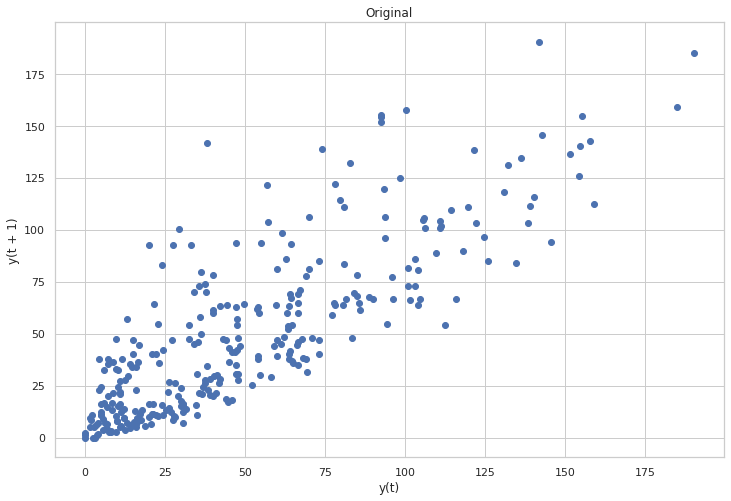

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


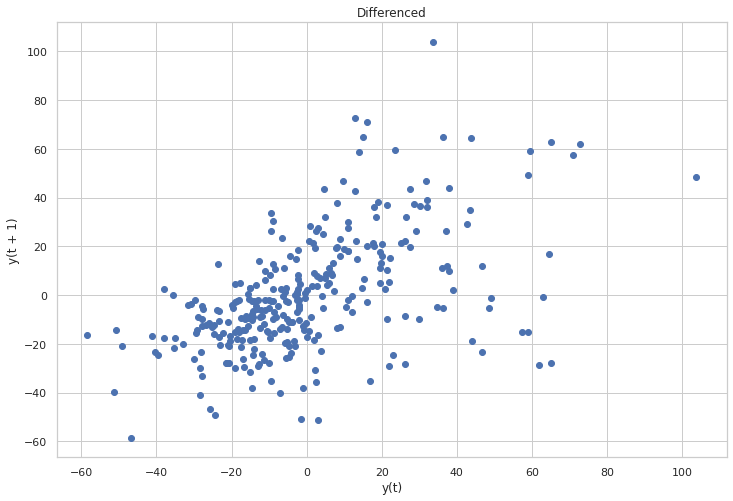

In [ ]:
#plotting lag plots
plt.figure(figsize=(12,8))
lag_plot(data.SUNACTIVITY)
plt.title('Original')
pyplot.show()
plt.figure(figsize=(12,8))
plt.title('Differenced')
lag_plot(diff_vals.sun_diff)




THe lag plot of the original time series shows some trend. This disappears for the differenced time series, as shown in the figures above.

**ACF and PACF of the original dataset**

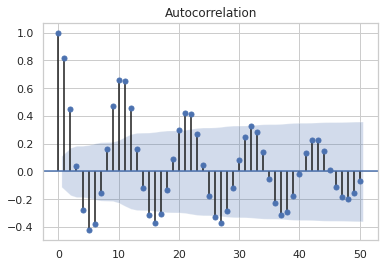

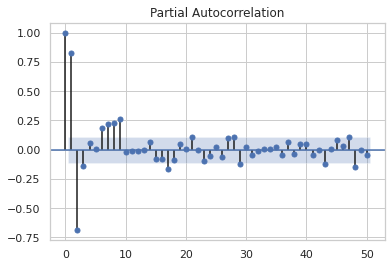

In [ ]:

plot_acf(data.SUNACTIVITY,lags=50,use_vlines=True)
pyplot.show()

plot_pacf(data.SUNACTIVITY,lags=50,use_vlines=True)
pyplot.show()

**ACF and PACF of the differenced dataset**

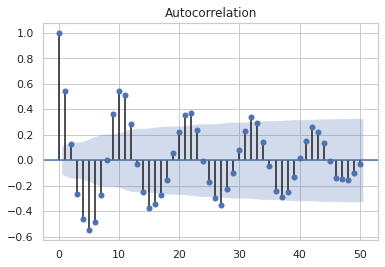

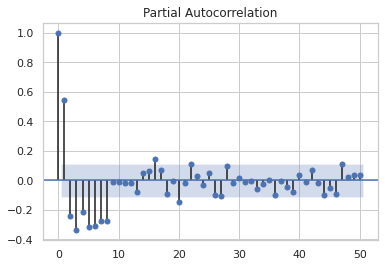

In [ ]:
plot_acf(diff_vals.sun_diff,lags=50,use_vlines=True,alpha=0.05)
pyplot.show()
plot_pacf(diff_vals.sun_diff,lags=50,use_vlines=True)
pyplot.show()

**EStimating ARIMA paramenters(p,d,q) using GridSearch(with least MSE)**

In [ ]:
def eval_arima_model(dataset,order):
  
  train_size = int(len(dataset)*0.65)
  train,test = dataset[0:train_size],dataset[train_size:]
  history = [x for x in train]
  preds = []
  for b in range(len(test)):
    model = ARIMA(history,order = order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test[b])

  mse = mean_squared_error(test,preds)
  
  return mse



def eval_models(dataset,pvals,dvals,qvals):
  dataset = dataset.astype("float32")
  best_mse,best_params = float("inf"),None
  for p in pvals:
    for d in dvals:
      for q in qvals:
        order = (p,d,q)
        try:
          mse = eval_arima_model(dataset,order)
          if mse < best_mse:
            best_mse,best_params = mse,order
          
          print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
          continue
  print('BEST ARIMA%s MSE=%.3f' % (best_params,best_mse))

In [ ]:
pvals = range(2,6)
dvals = range(0, 3)
qvals = range(2,10)
warnings.filterwarnings("ignore")
eval_models(diff_vals['sun_diff'].values, pvals, dvals,qvals)

ARIMA(2, 0, 3) MSE=311.555
ARIMA(2, 0, 4) MSE=313.747
ARIMA(2, 0, 5) MSE=302.248
ARIMA(2, 0, 6) MSE=303.840
ARIMA(2, 0, 7) MSE=307.838
ARIMA(2, 0, 8) MSE=310.673
ARIMA(2, 0, 9) MSE=316.393
ARIMA(2, 1, 2) MSE=578.445
ARIMA(2, 1, 3) MSE=300.053
ARIMA(2, 1, 4) MSE=538.942
ARIMA(2, 1, 5) MSE=579.689
ARIMA(2, 1, 6) MSE=484.686
ARIMA(2, 1, 7) MSE=450.328
ARIMA(2, 1, 8) MSE=447.095
ARIMA(2, 1, 9) MSE=394.872
ARIMA(2, 2, 2) MSE=735.967
ARIMA(2, 2, 3) MSE=768.514
ARIMA(2, 2, 4) MSE=779.183
ARIMA(2, 2, 5) MSE=669.244
ARIMA(2, 2, 6) MSE=593.486
ARIMA(2, 2, 7) MSE=586.708
ARIMA(2, 2, 8) MSE=529.391
ARIMA(2, 2, 9) MSE=504.676
ARIMA(3, 0, 2) MSE=317.581
ARIMA(3, 0, 3) MSE=319.116
ARIMA(3, 0, 4) MSE=313.976
ARIMA(3, 0, 5) MSE=305.638
ARIMA(3, 0, 6) MSE=306.324
ARIMA(3, 0, 7) MSE=309.748
ARIMA(3, 0, 8) MSE=311.077
ARIMA(3, 0, 9) MSE=314.283
ARIMA(3, 1, 2) MSE=357.831
ARIMA(3, 1, 3) MSE=200795428718.433
ARIMA(3, 1, 4) MSE=301.723
ARIMA(3, 1, 5) MSE=570.801
ARIMA(3, 1, 6) MSE=511.105
ARIMA(3, 1, 8) MSE=

In [ ]:
pvals = range(6,10)
dvals = range(0, 3)
qvals = range(2,10)
warnings.filterwarnings("ignore")
eval_models(diff_vals['sun_diff'].values, pvals, dvals,qvals)

ARIMA(6, 0, 2) MSE=305.407
ARIMA(6, 0, 3) MSE=303.199
ARIMA(6, 0, 4) MSE=306.353
ARIMA(6, 0, 5) MSE=322.116
ARIMA(6, 0, 6) MSE=310.512
ARIMA(6, 0, 7) MSE=307.804
ARIMA(6, 0, 8) MSE=320.755
ARIMA(6, 0, 9) MSE=332.662
ARIMA(6, 1, 2) MSE=351.849
ARIMA(6, 1, 4) MSE=318.996
ARIMA(6, 1, 6) MSE=367.269
ARIMA(6, 1, 7) MSE=310.222
ARIMA(6, 1, 8) MSE=340.769
ARIMA(6, 1, 9) MSE=340.756
ARIMA(6, 2, 2) MSE=649.044
ARIMA(6, 2, 3) MSE=412.877
ARIMA(6, 2, 9) MSE=559.527
ARIMA(7, 0, 2) MSE=303.585
ARIMA(7, 0, 3) MSE=309.241
ARIMA(7, 0, 4) MSE=317.355
ARIMA(7, 0, 5) MSE=309.131
ARIMA(7, 0, 6) MSE=306.838
ARIMA(7, 0, 7) MSE=308.309
ARIMA(7, 0, 8) MSE=301.397
ARIMA(7, 0, 9) MSE=329.920
ARIMA(7, 1, 2) MSE=334.726
ARIMA(7, 1, 3) MSE=397.066
ARIMA(7, 1, 4) MSE=325.666
ARIMA(7, 1, 5) MSE=335.273
ARIMA(7, 1, 6) MSE=313.747
ARIMA(7, 1, 7) MSE=310.990
ARIMA(7, 1, 8) MSE=303.999
ARIMA(7, 1, 9) MSE=320.793
ARIMA(7, 2, 3) MSE=366.314
ARIMA(7, 2, 5) MSE=775.242
ARIMA(7, 2, 8) MSE=410.199
ARIMA(7, 2, 9) MSE=349.999
A

From the above steps, BEST ARIMA parameters obtained are : p = 9, d = 2, q = 3.

**Visualising seasonal decomposition**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

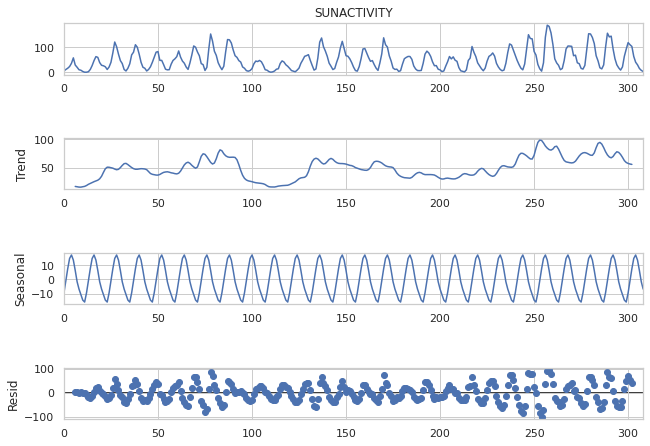

In [ ]:

result = seasonal_decompose(data['SUNACTIVITY'], model='additive', freq=12)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10,7)

In [ ]:
data.isnull().sum()

YEAR           0
SUNACTIVITY    0
sun_diff       1
dtype: int64

1. **ARIMA(9,0,0)**

Test MSE: 293.047
Test RMSE: 17.119
Test R2SCORE: 0.869


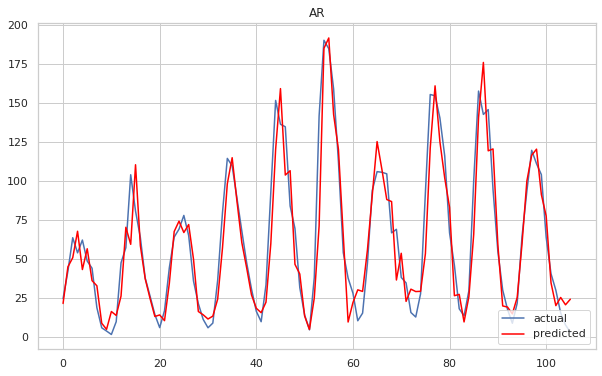

In [ ]:
X = data['SUNACTIVITY'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []

for t in range(len(test)):
	model = ARIMA(history, order=(9,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')


   
ax.legend(loc='lower right')
plt.title('AR')

pyplot.show()

2. **ARIMA(0,0,3)**

Test MSE: 490.999
Test RMSE: 22.158
Test R2SCORE: 0.780


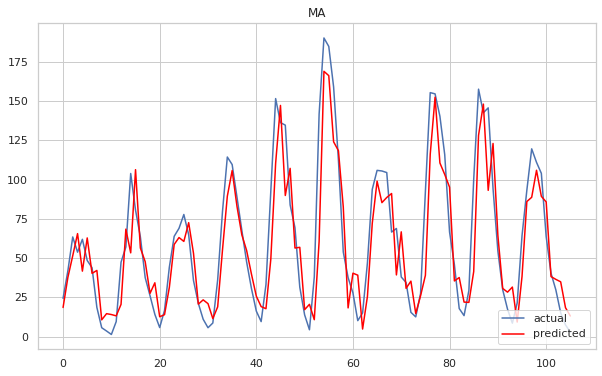

In [ ]:
X = data['SUNACTIVITY'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []

for t in range(len(test)):
	model = ARIMA(history, order=(0,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')


   
ax.legend(loc='lower right')
plt.title('MA')

pyplot.show()

3. **ARIMA(9,0,3)**

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

Test MSE: 324.704
Test RMSE: 18.020
Test R2SCORE: 0.854


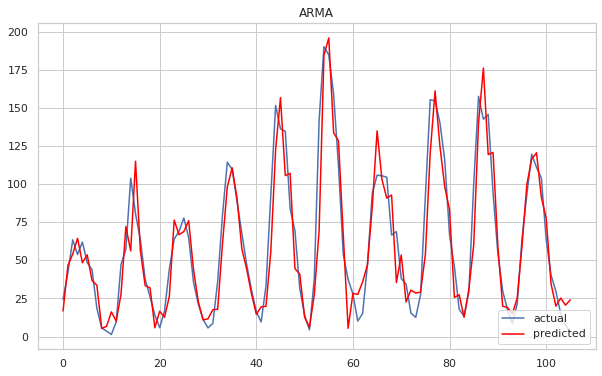

In [ ]:
X = data['SUNACTIVITY'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []

for t in range(len(test)):
	model = ARIMA(history, order=(9,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')


   
ax.legend(loc='lower right')
plt.title('ARMA')

pyplot.show()

4. **ARIMA(9,2,3)**

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

Test MSE: 300.941
Test RMSE: 17.348
Test R2SCORE: 0.865


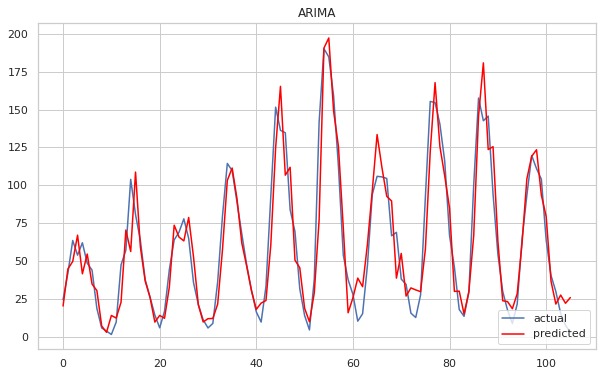

In [ ]:
X = data['SUNACTIVITY'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []

for t in range(len(test)):
	model = ARIMA(history, order=(9,2,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')


   
ax.legend(loc='lower right')
plt.title('ARIMA')

pyplot.show()

In [ ]:
msevals = pd.DataFrame(columns=['Models','Test MSE','Test R2score'])
msevals['Models'] = ['AR','MA','ARMA','ARIMA']
msevals['Test MSE'] = [293.047,490.999,324.704,309.941]
msevals['Test R2score'] = [0.869,0.78,0.854,0.865]
msevals

,Models,Test MSE,Test R2score
0,AR,293.047,0.869
1,MA,490.999,0.780
2,ARMA,324.704,0.854
3,ARIMA,309.941,0.865


**Seasonal ARIMA**

In [ ]:
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

In [ ]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):

    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(diff_vals.sun_diff, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results,columns=['params','aic'])

    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)
print(result_table)

#Set parameters that give the lowest AIC (Akaike Information Criteria)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 


           params          aic
0    (2, 2, 2, 2)    18.000000
1    (1, 2, 4, 3)    22.000000
2    (3, 2, 3, 4)    26.000000
3    (4, 4, 0, 1)  2566.701120
4    (2, 3, 0, 1)  2567.374606
..            ...          ...
613  (1, 2, 0, 0)  3010.955758
614  (1, 0, 0, 0)  3011.563464
615  (0, 0, 0, 0)  3011.623197
616  (0, 1, 0, 0)  3011.936510
617  (1, 1, 0, 0)  3013.050547

[618 rows x 2 columns]


In [ ]:
p, q, P, Q = result_table.params[0]

best_model = sm.tsa.statespace.SARIMAX(diff_vals.sun_diff, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                          sun_diff   No. Observations:                  308
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 5)   Log Likelihood                   0.000
Date:                           Mon, 19 Apr 2021   AIC                             18.000
Time:                                   15:15:14   BIC                             51.394
Sample:                                        0   HQIC                            31.361
                                           - 308                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9997    1.6e-05   1.25e+05      0.000       2.000       2.000
ar.L2         -0.9997        nan        nan

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


# **Forecasting using Deep Learning Approaches**


1.   Using DNN
2.   Using RNN

3.  
Using LSTM



*1. Using DNN*

In [ ]:
df_arr= diff_vals['sun_diff'].values
train_size = int(len(df_arr)*0.66)
test_size = len(df_arr)-(train_size)
test_size

105

In [ ]:
#reshaping dataset
def conv_to_matrix(array, back):
 X, Y =[], []
 for i in range(len(array)-back):
  d=i+back  
  X.append(array[i:d,0])
  Y.append(array[d,0])
 return np.array(X), np.array(Y)

train_size = int(len(diff_vals['sun_diff'].values)*0.9) #splitting dataset into train and test

df_arr= diff_vals['sun_diff'].values
df_arr = np.reshape(df_arr, (-1, 1))
test_size = len(df_arr)-(train_size)
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
back = 10
trainX, trainY = conv_to_matrix(train, back)
testX, testY = conv_to_matrix(test, back)


In [ ]:
#making a sequential model
def model_dnn(back):
    model=Sequential()
    model.add(Dense(units=32, input_dim=back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [ ]:
#training the model
back=10
model=model_dnn(back)
history=model.fit(trainX,trainY, epochs=500, batch_size=30, verbose=1, validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/500
9/9 [==============================] - 1s 35ms/step - loss: 492.9993 - mse: 492.9993 - mae: 18.1140 - val_loss: 478.8848 - val_mse: 478.8848 - val_mae: 18.1452
Epoch 2/500
9/9 [==============================] - 0s 7ms/step - loss: 399.1133 - mse: 399.1133 - mae: 15.8444 - val_loss: 353.3797 - val_mse: 353.3797 - val_mae: 14.6025
Epoch 3/500
9/9 [==============================] - 0s 8ms/step - loss: 344.4999 - mse: 344.4999 - mae: 14.2822 - val_loss: 290.6418 - val_mse: 290.6418 - val_mae: 13.0500
Epoch 4/500
9/9 [==============================] - 0s 8ms/step - loss: 308.8611 - mse: 308.8611 - mae: 13.4073 - val_loss: 264.4689 - val_mse: 264.4689 - val_mae: 12.7426
Epoch 5/500
9/9 [==============================] - 0s 8ms/step - loss: 283.1652 - mse: 283.1652 - mae: 12.7412 - val_loss: 252.6873 - val_mse: 252.6873 - val_mae: 12.4836
Epoch 6/500
9/9 [==============================] - 0s 8ms/step - loss: 263.3151 - mse: 263.3151 - mae: 12.1916 - val_loss: 247.6060 - val_mse: 2

In [ ]:
 def model_loss(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train Root Mean Squared Error(RMSE): 6.97; Train Mean Absolute Error(MAE) : 5.31 
Test Root Mean Squared Error(RMSE): 15.05; Test Mean Absolute Error(MAE) : 11.29 


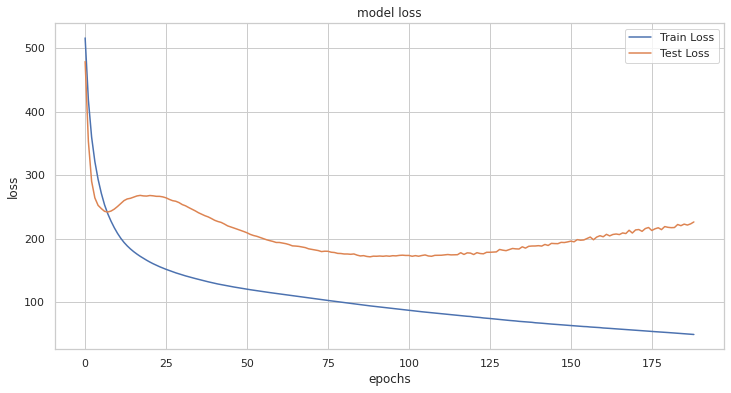

In [ ]:

train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [ ]:
   def prediction_plot(trainY, train_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(12,6))
      plt.plot(len_prediction, testY[:], marker='.', label="actual")
      plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
      plt.tight_layout()
      
      plt.title('SUNSPOTS')
      plt.ylabel('Sunactivity', size=15)
      plt.xlabel('Years', size=15)
      plt.legend(fontsize=15)
      plt.show();

In [ ]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)



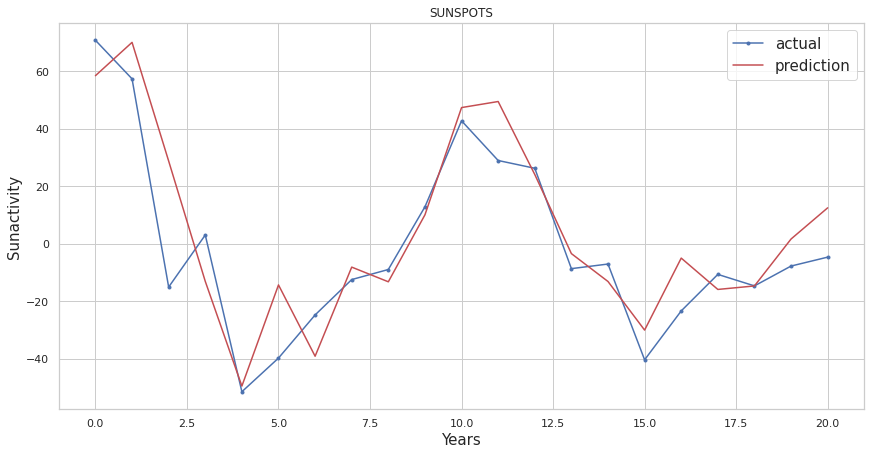

In [ ]:
prediction_plot(testX,test_predict)


2. *Using RNN*

In [ ]:
#defining model with 2 layers

def model_rnn(look_back):
  model=Sequential()
  model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
  return model

In [ ]:
model=model_rnn(look_back)
history=model.fit(trainX,trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX,testY),callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/100
7/7 [==============================] - 1s 52ms/step - loss: 0.1492 - mse: 0.1492 - mae: 0.3651 - val_loss: 0.1351 - val_mse: 0.1351 - val_mae: 0.3217
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.1158 - mse: 0.1158 - mae: 0.3157 - val_loss: 0.1087 - val_mse: 0.1087 - val_mae: 0.2769
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0878 - mse: 0.0878 - mae: 0.2669 - val_loss: 0.0852 - val_mse: 0.0852 - val_mae: 0.2338
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0640 - mse: 0.0640 - mae: 0.2176 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1923
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1711 - val_loss: 0.0495 - val_mse: 0.0495 - val_mae: 0.1591
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0304 - mse: 0.0304 - mae: 0.1354 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.1424
Epoch 7/100
7/7 [===========

Train Root Mean Squared Error(RMSE): 0.08; Train Mean Absolute Error(MAE) : 0.06 
Test Root Mean Squared Error(RMSE): 0.12; Test Mean Absolute Error(MAE) : 0.09 


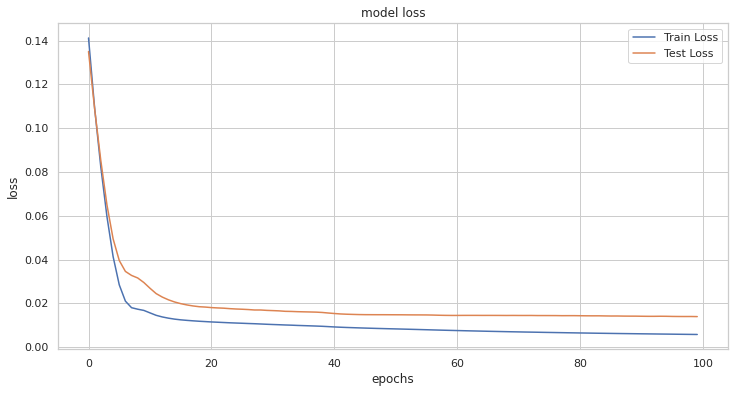

In [146]:

train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f '
      % (np.sqrt(mean_squared_error(trainY, train_predict[:,0])), mean_absolute_error(trainY, train_predict[:,0])))
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
      % (np.sqrt(mean_squared_error(testY, test_predict[:,0])), mean_absolute_error(testY, test_predict[:,0])))
model_loss(history)

In [156]:

def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(12,6))
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()
    
    plt.ylabel('Sunactivity', size=15)
    plt.xlabel('Years', size=15)
    plt.legend(fontsize=15)
    plt.title('SUNSPOTS')
    plt.show()

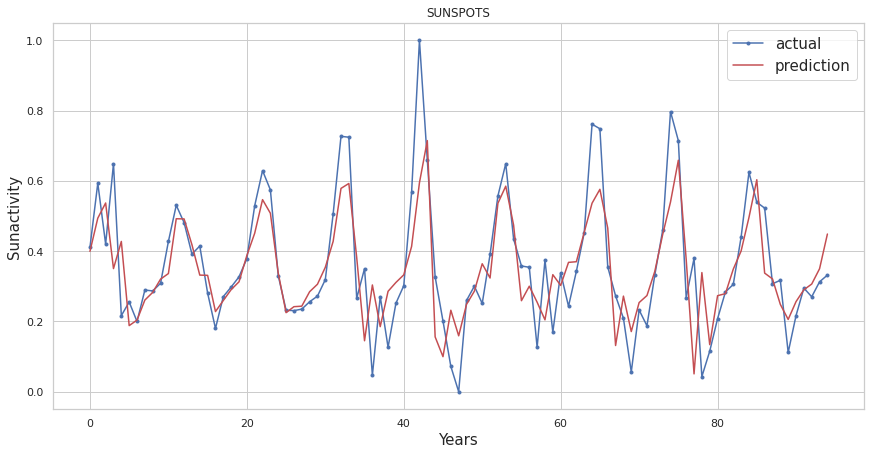

In [157]:
prediction_plot(testY, test_predict,look_back)

3. *Using LSTM*

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray
df_arr= diff_vals['sun_diff'].values
#diff_vals['sun_diff'].values = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1))
df_arr = scaler.fit_transform(df_arr)

In [ ]:

train_size = int(len(df_arr)*0.66)
test_size = len(df_arr)-(train_size)
test_size
test_size = len(df_arr)-(train_size)
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 10
trainX, trainY = conv_to_matrix(train, look_back)
testX, testY = conv_to_matrix(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:

def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

In [ ]:
model=model_lstm(look_back)
history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/100
7/7 [==============================] - 2s 60ms/step - loss: 0.1157 - mse: 0.1157 - mae: 0.3135 - val_loss: 0.1057 - val_mse: 0.1057 - val_mae: 0.2698
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0822 - mse: 0.0822 - mae: 0.2540 - val_loss: 0.0777 - val_mse: 0.0777 - val_mae: 0.2183
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0549 - mse: 0.0549 - mae: 0.1949 - val_loss: 0.0559 - val_mse: 0.0559 - val_mae: 0.1720
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1439 - val_loss: 0.0422 - val_mse: 0.0422 - val_mae: 0.1463
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1145 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1500
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.1099 - val_loss: 0.0375 - val_mse: 0.0375 - val_mae: 0.1579
Epoch 7/100
7/7 [===========

In [ ]:

train_predict = model.predict(trainX)
test_predict = model.predict(testX)


In [ ]:
 def model_loss(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train Root Mean Squared Error(RMSE): 0.09; Train Mean Absolute Error(MAE) : 0.06 
Test Root Mean Squared Error(RMSE): 0.11; Test Mean Absolute Error(MAE) : 0.09 


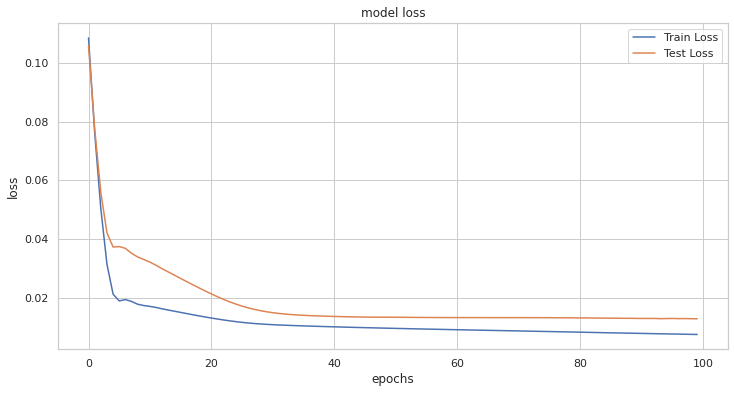

In [ ]:

train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))
model_loss(history)

In [ ]:

def prediction_plot(testY, test_predict,look_back):
    plt.figure(figsize=(12,6))
    len_prediction=[x for x in range(len(testY))]
    plt.plot(len_prediction, testY[:], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:], 'r', label="prediction")
    plt.tight_layout()

    plt.ylabel('SUNACTIVITY', size=15)
    plt.xlabel('Years', size=15)
    plt.legend(fontsize=15)
    plt.title('Sunspots')
    plt.show()

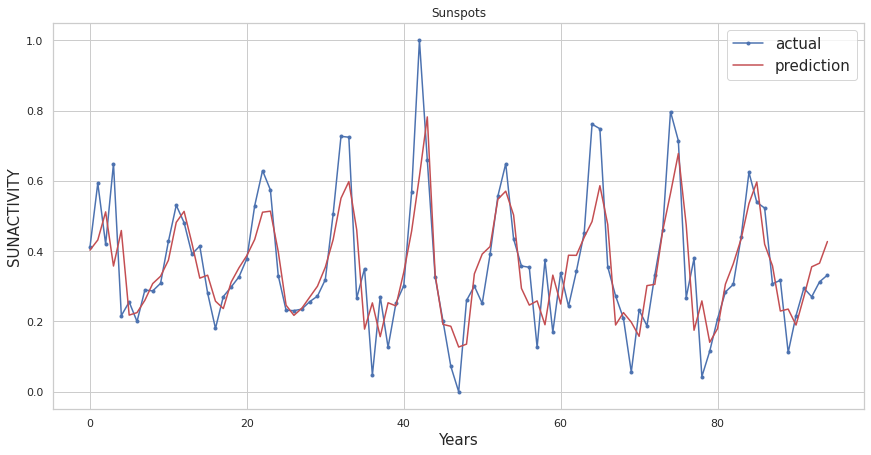

In [ ]:

prediction_plot(testY, test_predict,look_back)

# **Clustering**

1. **K-Means**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


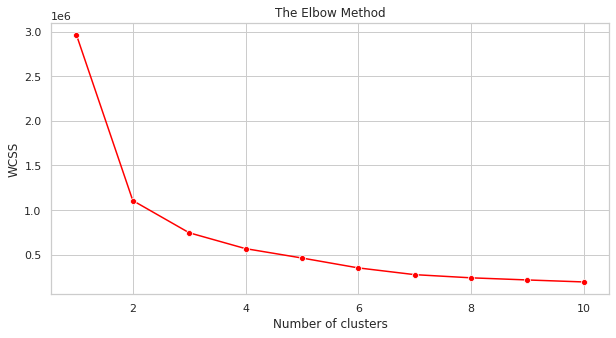

In [ ]:
X = data.iloc[:,[0,1]].values

# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

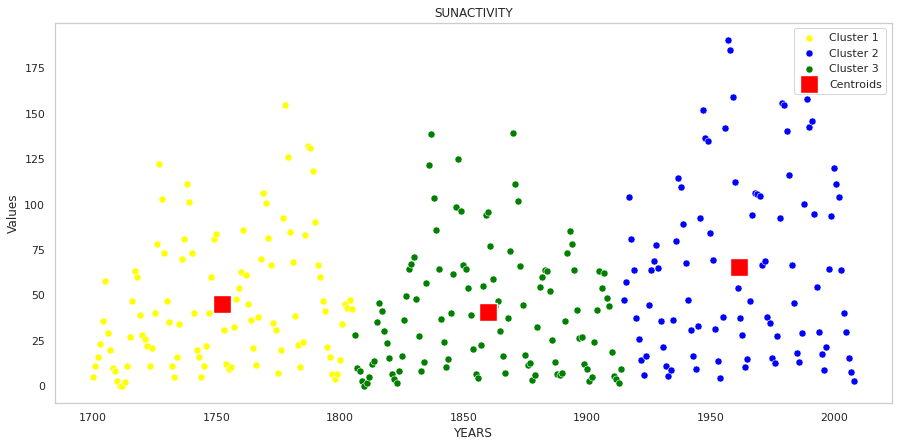

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('SUNACTIVITY')
plt.xlabel('YEARS')
plt.ylabel('Values')
plt.legend()
plt.show()

2. **AgglomerativeClustering**

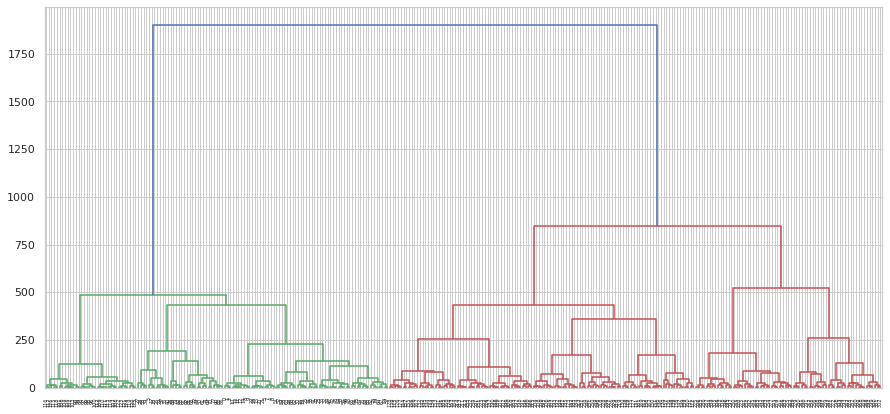

In [ ]:
plt.figure(figsize=(15,7))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_means = hc.fit_predict(X)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

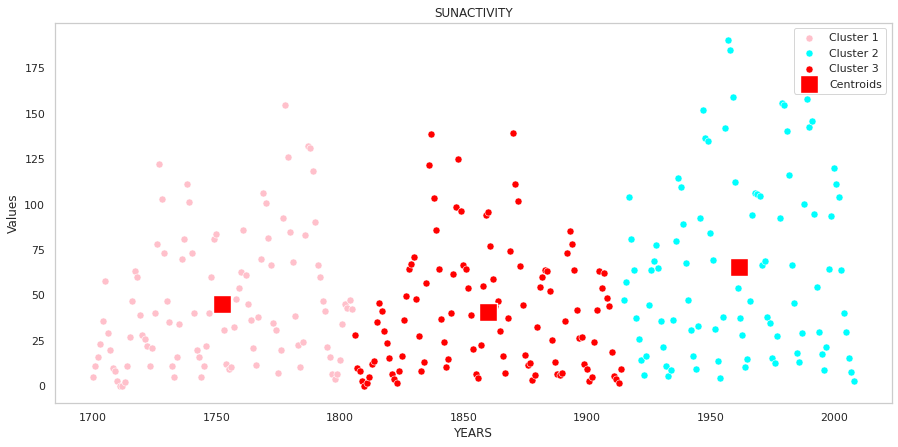

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0,0], X[y_kmeans == 0,1], color = 'pink', label = 'Cluster 1',s=50)
sns.scatterplot(X[y_kmeans == 1,0], X[y_kmeans == 1,1], color = 'cyan', label = 'Cluster 2',s=50)
sns.scatterplot(X[y_kmeans == 2,0], X[y_kmeans == 2,1], color = 'red', label = 'Cluster 3',s=50)

sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('SUNACTIVITY')
plt.xlabel('YEARS')
plt.ylabel('Values')
plt.legend()
plt.show()

# **Outlier Detection**

1. **InterQuartile Range Method**

In [ ]:

def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [ ]:

out_iqr(data,'SUNACTIVITY')

The IQR is 53.8
The lower bound value is -64.69999999999999
The upper bound value is 150.5
Total number of outliers are 8


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


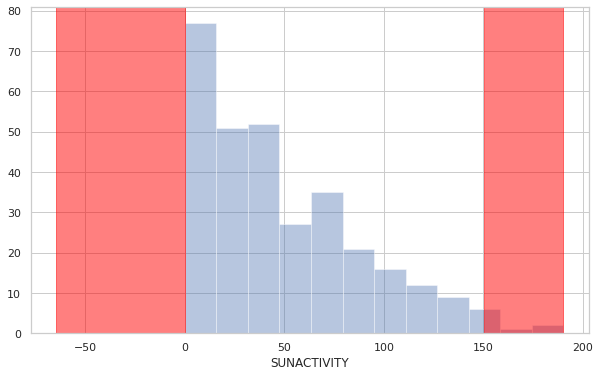

In [ ]:

plt.figure(figsize = (10,6))
sns.distplot(data.SUNACTIVITY, kde=False)
plt.axvspan(xmin = lower,xmax= data.SUNACTIVITY.min(),alpha=0.5, color='red')
plt.axvspan(xmin = upper,xmax= data.SUNACTIVITY.max(),alpha=0.5, color='red')

2. **Standard Deviation Method**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


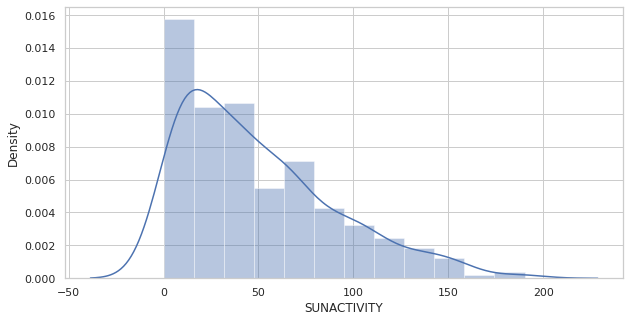

In [ ]:

plt.figure(figsize = (10,5))
sns.distplot(data['SUNACTIVITY'])

SInce the data is Gaussian, STD DEV method can be applied to check for outliers.

In [ ]:
def out_std(df, column):
    global lower,upper
    # calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
    # calculate the cutoff value
    cut_off = data_std * 3
    # calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [ ]:
out_std(data,'SUNACTIVITY')

The lower bound value is -71.60568131066171
The upper bound value is 171.10988843040286
Total number of outliers are 2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


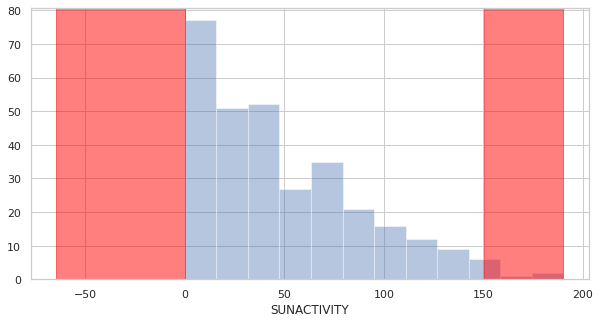

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(data.SUNACTIVITY, kde=False)
plt.axvspan(xmin = lower,xmax= data.SUNACTIVITY.min(),alpha=0.5, color='red')
plt.axvspan(xmin = upper,xmax= data.SUNACTIVITY.max(),alpha=0.5, color='red')

3. **Z-Score Method**

In [ ]:

def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers are",len(outliers))

In [ ]:
out_zscore(data.SUNACTIVITY)

Total number of outliers are 2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


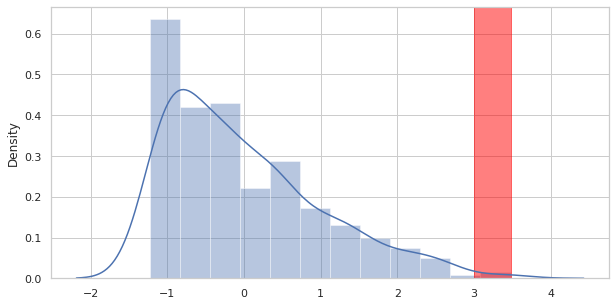

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.5, color='red')